In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

In [9]:
def grid_from_coarsening_factor(n, f):
    if f > 1:
        f = int(f)
        C = np.array([0]*n)
        for i in range((n-1)%f // 2, n, f):
            C[i] = 1
        return C
    else:
        C = np.array([1]*n)
        f = int(1/f)
        for i in range((n-1)%f // 2, n, f):
            C[i] = 0
        return C

def ideal_interpolation(A, picked_C):
    """
    Constructs an ideal interpolation operator.  Shamelessly stolen from Luke Olson's code.
    A - matrix system
    picked_C - boolean numpy array of size 'n' containing '1' for coarse points and '0' for fine points.
    returns prolongation matrix P, such that P=R^T
    """
    C = np.where(picked_C == 1)[0]
    F = np.where(picked_C == 0)[0]
    n = len(picked_C)

    A = A.todense()
    AFF = A[F,:][:,F]
    AFC = A[F,:][:,C]
    ACF = A[C,:][:,F]

    P = np.zeros((n, len(C)))
    P[C,:] = np.eye(len(C))
    P[F,:] = -np.linalg.inv(AFF) @ AFC

    return P

def display_grid(tf, ysize=3):
    plt.figure(figsize=(10,ysize))
    xs = np.linspace(-1, 1, len(tf))
    ys = np.zeros(len(tf))
    C = np.where(tf==1)
    F = np.where(np.logical_not(tf))
    plt.plot(xs[C], ys[C], 'rs', ms=15, markerfacecolor="None", markeredgecolor='red', markeredgewidth=2, label="C Pts")
    plt.plot(xs[F], ys[F], 'bo', ms=15, markerfacecolor="None", markeredgecolor='blue', markeredgewidth=2, label="F Pts")
    plt.legend()

def jacobi(A, x, b, omega=0.66, nu=2):
    D = A.diagonal()
    Dinv = sp.diags(1/D, 0)
    n = A.shape[0]
    for i in range(nu):
        x = omega * Dinv@b + (sp.eye(n) - omega * Dinv@A) @ x
    return x
    
def mgv(A, P, x, b, nu=2):
    x = jacobi(A, x, b, nu=nu)
    rH = P.T@(b-A@x)
    AH = P.T@A@P
    x += P@la.solve(AH, rH)
    x = jacobi(A, x, b, nu=nu)
    return x

In [3]:
L = 1
N = 31
h = 1/(N+1)
A = ((sp.eye(N)*2 - sp.eye(N,k=-1) - sp.eye(N,k=1)) / (h**2)).tocsr()

In [4]:
def rand_guess(N):
    return (np.random.rand(N) * 2) - 1

In [5]:
#C = np.random.choice([0, 1], p=[0.75, 0.25], size=N, replace=True).flatten()
C = grid_from_coarsening_factor(N, 6)
P = ideal_interpolation(A,C)
x = rand_guess(N)

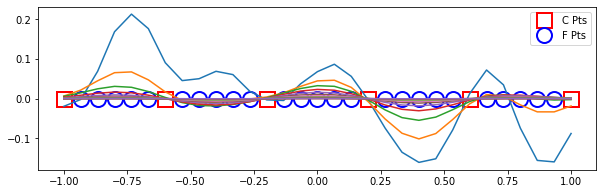

In [6]:
display_grid(C)
#plt.plot(np.linspace(-1,1,N), x, '-')

for i in range(15):
    x = mgv(A, P, x, np.zeros(N))
    plt.plot(np.linspace(-1,1,N), x, '-')

plt.savefig('multigrid.png', dpi=300)

In [19]:
def display_grid_condensed(tf):
    fig=plt.figure(figsize=(10,1))
    fig.patch.set_visible(False)
    plt.gca().axis('off')
    xs = np.linspace(-1, 1, len(tf))
    ys = np.zeros(len(tf))
    C = np.where(tf==1)
    F = np.where(np.logical_not(tf))
    plt.plot(xs[C], ys[C], 'rs', ms=15, markerfacecolor="None", markeredgecolor='red', markeredgewidth=2, label="C Pts")
    plt.plot(xs[F], ys[F], 'bo', ms=15, markerfacecolor="None", markeredgecolor='blue', markeredgewidth=2, label="F Pts")
    #plt.legend()

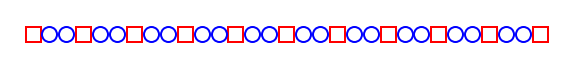

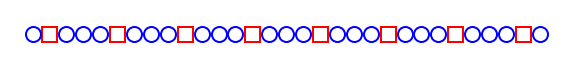

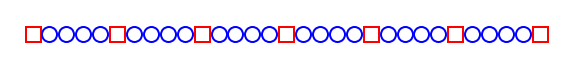

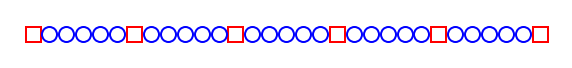

In [23]:
C = grid_from_coarsening_factor(N, 3)
display_grid_condensed(C)
C = grid_from_coarsening_factor(N, 4)
display_grid_condensed(C)
C = grid_from_coarsening_factor(N, 5)
display_grid_condensed(C)
C = grid_from_coarsening_factor(N, 6)
display_grid_condensed(C)